<a href="https://colab.research.google.com/github/RamoRema96/Esoneri/blob/main/Esonero_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf MS_vertex_esonero.npz
!wget http://giagu.web.cern.ch/giagu/CERN/MS_vertex_esonero.npz 

--2022-06-14 13:48:53--  http://giagu.web.cern.ch/giagu/CERN/MS_vertex_esonero.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106576990 (102M)
Saving to: ‘MS_vertex_esonero.npz’

MS_vertex_esonero.n 100%[===================>] 101.64M  36.3MB/s    in 2.8s    

2022-06-14 13:48:56 (36.3 MB/s) - ‘MS_vertex_esonero.npz’ saved [106576990/106576990]



first data shape (1000, 20, 333)
Questa è la shape iniziale (1000, 6660)
(1000,)


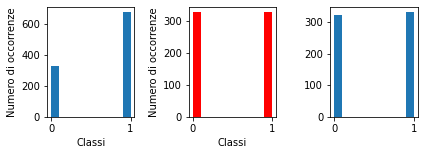

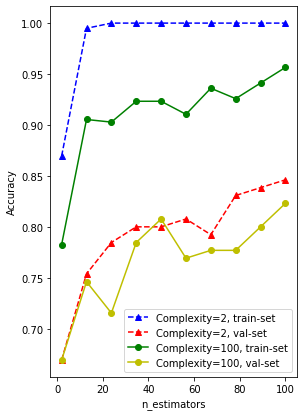

Test score:  0.8549618320610687
Questi sogno gli score con la cross validation:  [0.87022901 0.90076336 0.85384615 0.8        0.82307692]
Confusion Matrix:
[[0.9        0.1       ]
 [0.18309859 0.81690141]]
              precision    recall  f1-score   support

     class 0       0.81      0.90      0.85        60
     class 1       0.91      0.82      0.86        71

    accuracy                           0.85       131
   macro avg       0.86      0.86      0.85       131
weighted avg       0.86      0.85      0.86       131



In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.decomposition import PCA
import random 

inp_file = np.load('MS_vertex_esonero.npz')
data = inp_file['data']
target = inp_file['target']
print("first data shape", data.shape)
data=data.reshape(1000,6660)
print("Questa è la shape iniziale", data.shape)
print(target.shape)
prompt= target <=1.5
displaced= target>1.5 
target[prompt]=0
target[displaced]=1  ## Ho diviso il target in 2 classi, prompt e displaced 

## Controllo se le classi sono distribuite in maniera più o meno equa ( vedo se il dataset non è non è sbilanciato)
plt.subplot(2,3,1)
plt.hist(target)
plt.xlabel("Classi")
plt.ylabel("Numero di occorrenze")

# Le classi sono un pò sbilanciate, 70:30 è il rapporto..faccio due cose alleno il modello prima con le classi bilanciate e poi 
# dopo in un altro script così come sono e vedo un pò la differenza

classe_1=(sum(target))              ## Sto vedendo il numero di occorrenze delle classsi 0 e 1 
classe_0=len(target)-classe_1    
n=[classe_1, classe_0]  
n_eventi=min(n)

## Mi creo un dataframe con gli eventi e i target in modo da poter poi fare uno shuffle e prendere in maniera equilibrata le classi


data2=pd.DataFrame(list(zip(data, target)), columns=["Dati", "Target"])

data2=data2.sample(frac=1) ## Sto facendo uno shuffle del dataframe
data2=data2.groupby("Target").head(n_eventi)  ##Mi sto prendendo ricreando il dataset in maniera tale da avere classi equilibrate

target2=data2["Target"]
dati=data2.drop("Target", axis=1)
plt.subplot(2,3,2)
plt.hist(target2, color="r")
plt.xlabel("Classi")
plt.ylabel("Numero di occorrenze")
plt.tight_layout()


## Me li ritrasformo in array numpy ora 
target2=target2.values
dati=dati.values


##Provo a fare la groupby con gli array 

indici_1={}
for i in range (len(target)):
    indici_1[i]=target[i]

dati_nuovi=[]
target_nuovi=[]

n_eventi=n_eventi+n_eventi

while (len(target_nuovi) != n_eventi):
  num=random.randint(0, len(target)-1)
  if (indici_1[num]==1):
    prob=random.random()
    if (prob<0.33):
      dati_nuovi.append(data[num])
      target_nuovi.append(target[num])
  else:
    prob=random.random()
    if (prob>0.33):
      dati_nuovi.append(data[num])
      target_nuovi.append(target[num])


## Me so dovuto fare la groupby con gli array perchè quando convertivo il dataframe in numpy array mi faceva un sacco di casini, no reshape etc etc.. 

    
                
dati_nuovi=np.array(dati_nuovi)
target_nuovi=np.array(target_nuovi)
plt.subplot(2,3,3)

plt.hist(target_nuovi)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
#Dividiamo il dataset in training, test e validation 


X_train,X,Y_train,Y=train_test_split(dati_nuovi,target_nuovi,train_size=0.6, shuffle=True)
X_vali,X_test,Y_vali,Y_test=train_test_split(X,Y,train_size=0.5, shuffle=True)

estimators=np.linspace(2,100,10)
complexity=[2,100]

Score_train=[[], []]
Score_Val=[[], []]
Score_oob=[[], []]



for i in range(len(complexity)):
  

  for j in range(len(estimators)):
    

    RF=RandomForestClassifier(n_estimators=int(estimators[j]), min_samples_split=complexity[i])
    RF.fit(X_train, Y_train)
    score=RF.score(X_train, Y_train)
    score_val=RF.score(X_vali, Y_vali)
    Oob=RF.oob_score
    
    Score_train[i].append(score)
    Score_Val[i].append(score_val)
    Score_oob[i].append(Oob)

    #print("Score_train, Score_val, Oob_score: \n", score, score_val, Oob)
plt.figure(figsize=(15,15))
plt.subplot(2,3,4)
plt.plot(estimators, Score_train[0], "--b^", label="Complexity=2, train-set")
plt.plot(estimators, Score_Val[0], "--r^", label="Complexity=2, val-set")
#plt.plot(estimators, Score_oob[0], "--c^", label="Complexity=2, oob")
plt.plot(estimators, Score_train[1], "o-g", label="Complexity=100, train-set")
plt.plot(estimators, Score_Val[1], "o-y", label="Complexity=100, val-set")
#plt.plot(estimators, Score_oob[1], "o-m^", label="Complexity=100, oob")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

best_estimators=estimators[Score_Val[0].index(max(Score_Val[0]))]
RF=RandomForestClassifier()
RF.fit(X_train, Y_train)

test_score=RF.score(X_test, Y_test)
print("Test score: ", test_score)


from sklearn.model_selection import cross_val_score
scores = cross_val_score(RF, dati_nuovi, target_nuovi, cv=5)
print("Questi sogno gli score con la cross validation: ", scores)

from sklearn.metrics import confusion_matrix
predict=RF.predict(X_test)
c_mat = confusion_matrix(Y_test, predict, normalize='true')
print("Confusion Matrix:")
print(c_mat)

from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, predict , target_names=target_names))